<a href="https://colab.research.google.com/github/NitaiHalle/machine-learning/blob/master/hw2_AE_with_pix_by_pix_notes.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Deep Learning :H.W 2</br>

### Or Wertheim and Nitai Halle</br>

### 3. Specific Tasks


Imports

In [ ]:
import numpy as np
import matplotlib 
from matplotlib import pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch import Tensor
import copy
import torch.nn.utils as utils
import torchvision
from torchvision import datasets,transforms
import random

_Some plot functions_

In [ ]:
cpu = torch.device("cpu")

def plot2seq(seq1,seq2,title, label_seq1 = 'Sequence 1', label_seq2='Sequence 2',x_label='time',y_label='value'):
  if isinstance(seq1, Tensor):
      seq1 = seq1.to(cpu)
      if seq2 is not None:
        seq2 = seq2.to(cpu)
  plt.figure()
  plt.plot(range(1,len(seq1)+1),seq1, label=label_seq1)
  if seq2 is not None:
    plt.plot(range(1,len(seq2)+1),seq2, label=label_seq2)
  plt.title(title)
  plt.xlabel(x_label)
  plt.ylabel(y_label)
  plt.legend(loc='upper right')
  plt.show()

def plotSeq(seq1,title, label_seq = 'Sequence 1',x_label='time',y_label='value'):
  plot2seq(seq1,None,title,label_seq1=label_seq,x_label=x_label,y_label=y_label)

def plotLossVsTime(hist, on_train=None):
    loss=None
    if on_train is None:
        plotLossVsTime(hist, on_train=True)
        plotLossVsTime(hist, on_train=False)
        return
    if on_train:
        title='Train loss vs time(epoch)'
        loss = hist['train_loss']
    else:
        loss=hist['val_seq_mse']
        title='Prediction loss vs time(epoch)'
    plotSeq(loss,title, label_seq = 'Loss',x_label='time',y_label='loss')

def plotLossAndAccuracyVsTime(hist1,hist2, labelHist1,labelHist2):

    if len(hist2['val_cat_accuracy']) > 0:
        plotSeq(hist2['val_cat_accuracy'],'MNIST classification accuracy', label_seq = labelHist2,x_label='time',y_label='accuracy')
    else:
        plotSeq(hist1['val_cat_accuracy'],'MNIST classification accuracy', label_seq = labelHist1,x_label='time',y_label='accuracy')
    plot2seq(hist1['val_seq_mse'],hist2['val_seq_mse'],'Test MSE_loss(reconstruction,real) vs Epochs', label_seq1 = labelHist1, label_seq2=labelHist2,x_label='epochs',y_label='MSE loss')
    plot2seq(hist1['train_loss'],hist2['train_loss'],'Train loss vs Epochs', label_seq1 = labelHist1, label_seq2=labelHist2,x_label='epochs',y_label='loss')

### Genrate Synthetic Data
10,000 input sequences of length 50 the values ∈ [0,1].</br>We sample a random integer i ∈ [20, 30] for each sequence s.t values in indexes
[i − 5, i + 5] are multiplyied by 0.1

In [ ]:
numOfExamples=10000
sequenceLen = 50
syntheticData_inputSize =1
syntheticData = torch.rand((sequenceLen,numOfExamples))
syntheticData = syntheticData.view(syntheticData.shape[0],syntheticData.shape[1],syntheticData_inputSize)
randI = torch.randint(low=20, high=30, size=(numOfExamples,))
for exampleInd in range(numOfExamples): 
  syntheticData[(randI[exampleInd]-5):(randI[exampleInd]+5),exampleInd] *=0.1

train = syntheticData[:,:int(0.6*numOfExamples)]

val = syntheticData[:,int(0.6*numOfExamples):int(0.6*numOfExamples)+int(0.2*numOfExamples)]
test = syntheticData[:,int(0.6*numOfExamples) + int(0.2*numOfExamples):]
print('Data dimensions:',syntheticData.size())
print('Train data size:',train.shape[1])
print('Validation data size:',val.shape[1])
print('Test data size:',test.shape[1])

Data dimensions: torch.Size([50, 10000, 1])
Train data size: 6000
Validation data size: 2000
Test data size: 2000


### 3.1.1 Two examples from the synthetic dataset
This is a graph of signal value vs. time for each example

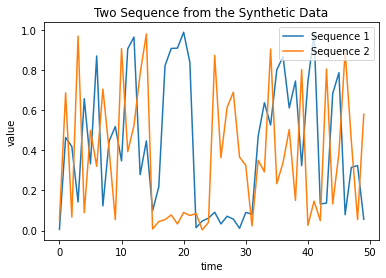

In [ ]:
p = np.random.permutation(numOfExamples)
plot2seq(syntheticData[:,p[0]],syntheticData[:,p[1]],'Two Sequence from the Synthetic Data')

## 3.1.2

#### our LSTM auto-encoder implementation
For the decoder we tried to train using the input and the last decoder hidden state, and we saw that (surprisingly) using only the hidden state gave us better results.
Our implementation encodes the input into an hidden state and then the decoder reconstructs the original sequence.



In [ ]:
class LSTM_AE(nn.Module):

    def __init__(self, input_size, hidden_size):
        super(LSTM_AE, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.lstmEncoder = nn.LSTM(input_size = input_size, hidden_size = hidden_size)
        self.lstmDecoder = nn.LSTM(input_size = hidden_size, hidden_size = hidden_size)
        # The linear layer that maps from hidden state space to input space
        self.hidden2output = nn.Linear(hidden_size, input_size)

    def forward(self, x):
        lstm_out, (hidden,cell) = self.lstmEncoder(x.view(x.shape[0], x.shape[1], self.input_size))
        hidden = hidden.repeat(x.shape[0],1,1)
        lstm_out, (hidden,_) = self.lstmDecoder(hidden.view(x.shape[0], x.shape[1], -1))
        output = self.hidden2output(lstm_out)
        return output

### The train Loop

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def train_model(model, train_x, val_x, n_epochs, batchSize=8, clip_max_grad = 1, lr=0.001, train_c=None, val_c=None, more_prints=False,predictionMSE=False):
  model = model.to(device)
  optimizer = torch.optim.Adam(model.parameters(), lr)
  criterionMSE = nn.MSELoss().to(device)
  criterionCE = nn.CrossEntropyLoss().to(device)
  num_examples = train_x.shape[1]
  num_examples_val = val_x.shape[1]

  history = dict(train_loss=[], val_seq_mse=[], val_cat_accuracy=[])

  best_model_wts = copy.deepcopy(model.state_dict())
  best_loss = 10000.0
  

  for epoch in range(1, n_epochs + 1):
    model = model.train()
    loss_epoch=0
    train_losses = []

    trimmedNumOfExamples = num_examples - (num_examples % batchSize)#trim the train set to fit minibatch size
    numOfMiniBatch = int(trimmedNumOfExamples/batchSize)
    miniBatches =  np.split(np.random.permutation(trimmedNumOfExamples),numOfMiniBatch) #divide dataset to random mini batches
    miniBatches = np.array(miniBatches)
    for j in range(int(numOfMiniBatch)):
      batch_x = train_x[:,miniBatches[j],:]
      batch_x = batch_x.to(device)
      batch_c = None
      if train_c is not None:
        if len(train_c.size())==3:#when each prediction is a sequence (like in section 3.3.4)
            batch_c = train_c[:,miniBatches[j],:]
        else:#when each prediction is a scalar
            batch_c = train_c[miniBatches[j]]
        batch_c = batch_c.to(device)
      optimizer.zero_grad()
      model_out=model(batch_x)
      pred_seq,pred_class=None,None

      if train_c is not None:
        pred_seq,pred_class=model_out
        if len(train_c.size())==3:
            pred_class = pred_class#.view(pred_class.shape[1],pred_class.shape[2])
        else:
            pred_class = pred_class.view(pred_class.shape[1],pred_class.shape[2])
      else:
        pred_seq = model_out
      pred_seq = pred_seq.to(device)
      loss = criterionMSE(pred_seq, batch_x)
      if train_c is not None:
        batch_c = batch_c.to(device)
        loss2=None
        if predictionMSE:
            loss2 = criterionMSE(pred_class,batch_c)
        else:
            loss2 = criterionCE(pred_class,batch_c)
        loss = loss2+loss
      loss.backward()
      if clip_max_grad != 0:
        utils.clip_grad_norm_(model.parameters(), clip_max_grad)
      optimizer.step()
      if more_prints:
          print('epoch mini batch loss:',loss.item()/numOfMiniBatch, ', Total miniBatches:',numOfMiniBatch)
      loss_epoch += loss.item()/numOfMiniBatch#
    train_losses.append(loss_epoch)

    val_losses = []
    trimmedNumOfExamples_val = num_examples_val - (num_examples_val % batchSize)#
    numOfMiniBatch_val = int(trimmedNumOfExamples_val/batchSize)
    miniBatches_val =  np.array(np.split(np.random.permutation(trimmedNumOfExamples_val),numOfMiniBatch_val))

    model = model.eval()
    score=0
    for j in range(int(numOfMiniBatch_val)):
        with torch.no_grad():
            batch_x = val_x[:,miniBatches_val[j],:]
            batch_x = batch_x.to(device)
            batch_c = None
            if train_c is not None:
                if len(train_c.size())==3:#when each prediction is a sequence
                    batch_c = val_c[:,miniBatches_val[j],:]
                else:#when each prediction is a scalar
                    batch_c = val_c[miniBatches_val[j]]
                batch_c = batch_c.to(device)

                pred_seq,pred_class=model.predict(batch_x)
                if predictionMSE:
                    score += criterionMSE(pred_class,batch_c)/numOfMiniBatch_val
                else:
                    score += (pred_class.view(-1) == batch_c.view(-1)).sum()
            else:
                pred_seq = model(batch_x)
            pred_seq = pred_seq.to(device)
            loss = criterionMSE(pred_seq, batch_x)
            val_losses.append(loss.item())
    if predictionMSE:
        history['val_cat_accuracy'].append(score)
    else:
        history['val_cat_accuracy'].append(int(score)/ val_x.shape[1])
    train_loss = np.mean(train_losses) 
    val_loss = np.mean(val_losses)

    history['train_loss'].append(train_loss)
    history['val_seq_mse'].append(val_loss) 
    if val_loss < best_loss:
       best_loss = val_loss
       best_model_wts = copy.deepcopy(model.state_dict())
    #print(f'Epoch {epoch}: train loss {train_loss} val loss {val_loss}')

  #Load the best model parameters to the model
  model.load_state_dict(best_model_wts)
  model = model.to(cpu)
  return history

We will train and perform a grid search of the hyperparameters:</br>
_hidden state size (all options are below 50 because we need to avoid learning the identity function), learning rate_, and _gradient clipping_.

In [ ]:
lr_values=[1e-2,1e-3]
hidden_size_values = [20,40,48]
clipping_values=[0,1,3]
models = []
epoches=200

mle_criterion = nn.MSELoss()

for lr in lr_values:
  for hs in hidden_size_values:
    for clip in clipping_values:
      model = LSTM_AE(syntheticData_inputSize, hs)
      train_model(model, train, val, epoches, batchSize=32,clip_max_grad=clip, lr=lr)
      with torch.no_grad(): 
        pred = model(val)
        loss_val = mle_criterion(pred, val)
        pred = model(train)
        loss_train = mle_criterion(pred, train)
        models.append((model,lr,hs,clip,loss_val.item(),loss_train.item()))


Lets Print our results:

In [ ]:
for conf in models:
  print('hiddenSize:',conf[2], ', max value for clipping:',conf[3],' learning rate:',conf[1], ', loss(validation):',conf[4],', loss(train):',conf[5])

hiddenSize: 20 , max value for clipping: 0  learning rate: 0.01 , loss(validation): 0.03493877127766609 , loss(train): 0.03495202586054802
hiddenSize: 20 , max value for clipping: 1  learning rate: 0.01 , loss(validation): 0.03657638654112816 , loss(train): 0.03698098286986351
hiddenSize: 20 , max value for clipping: 3  learning rate: 0.01 , loss(validation): 0.035831961780786514 , loss(train): 0.035990167409181595
hiddenSize: 40 , max value for clipping: 0  learning rate: 0.01 , loss(validation): 0.01131533645093441 , loss(train): 0.010968889109790325
hiddenSize: 40 , max value for clipping: 1  learning rate: 0.01 , loss(validation): 0.027376364916563034 , loss(train): 0.027244534343481064
hiddenSize: 40 , max value for clipping: 3  learning rate: 0.01 , loss(validation): 0.01707371324300766 , loss(train): 0.0169146079570055
hiddenSize: 48 , max value for clipping: 0  learning rate: 0.01 , loss(validation): 0.014361034147441387 , loss(train): 0.014136864803731441
hiddenSize: 48 , max 

We will show the results of our best model (not showing all of the models result to keep the report length short as requested):

The Best Model parameters are:
hiddenSize: 40 , max value for clipping: 0  learning rate: 0.01


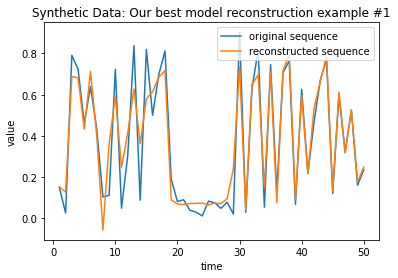

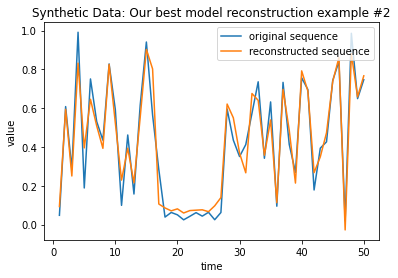

In [ ]:
bst_model=None
best_conf=None
best_val_lost = 3000
for conf in models:
  if best_val_lost>conf[4]:
    best_val_lost=conf[4]
    bst_model=conf[0]
    best_conf =conf
print('The Best Model parameters are:')
print('hiddenSize:',best_conf[2], ', max value for clipping:',best_conf[3],' learning rate:',best_conf[1])

with torch.no_grad():
  p = np.random.permutation(len(test))
  ind_s=p[0]
  ind_e = p[0]+2
  test_ = test[:,ind_s:ind_e]
  test_=test_.to(device)
  bst_model.to(device)
  pred = bst_model(test_)
  plot2seq(test_[:,0],pred[:,0],'Synthetic Data: Our best model reconstruction example #1',label_seq1='original sequence',label_seq2='reconstructed sequence')
  plot2seq(test_[:,1],pred[:,1],'Synthetic Data: Our best model reconstruction example #2',label_seq1='original sequence',label_seq2='reconstructed sequence')

### 3.2 Reconstructing and classifying MNIST images
Loading MNIST data</br>
We use the pytorch loader, and we take the whole data as a single minibatch,
so it will be easy to preprocess it.</br>
The loader normalize the data.

In [ ]:
mnistSize=60000
train_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=True, download=True,
                   transform=transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,))
                   ])),
    batch_size=mnistSize, shuffle=True)
test_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=False, transform=transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,))
                   ])),
    batch_size=mnistSize, shuffle=True)

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ../data/MNIST/raw/train-images-idx3-ubyte.gz to ../data/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ../data/MNIST/raw/train-labels-idx1-ubyte.gz to ../data/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ../data/MNIST/raw/t10k-images-idx3-ubyte.gz to ../data/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ../data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ../data/MNIST/raw



We preprocess the data to be time series of rows,
we also change the data shape to fit torch.LSTM input.</br>
_<sequence length, batch size, input size>_

In [ ]:
def pre_proccess_mnist(loader,sequnceLength=28, inputSize=28):
  for batch_idx, (data, target) in enumerate(loader):
    data_v = data.view(-1,sequnceLength, inputSize)
    data_v = data_v.permute(1, 0, 2)

    return data_v,target
mnist_test_x,mnist_test_c = pre_proccess_mnist(test_loader)
mnist_train_x, mnist_train_c = pre_proccess_mnist(train_loader)

###3.2.1 Train the LSTM AE to reconstruct MNIST images

In [ ]:
model_mnist = LSTM_AE(28, 100)
mnist_hist=train_model(model_mnist, mnist_train_x, mnist_test_x, 10, batchSize=32,clip_max_grad=1, lr=1e-3)

We will show three examples of the each digit 'I' (as in mnist) and its reconstructions.</br>
We simply go over the MNIST test data untill we see take the first three examples of the digit and test on them.

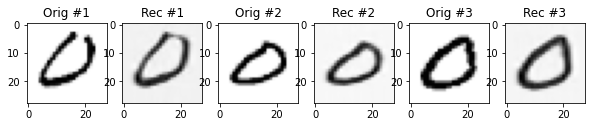

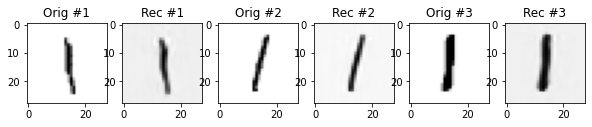

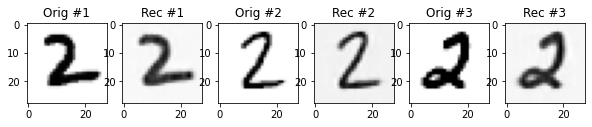

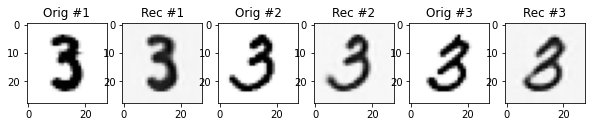

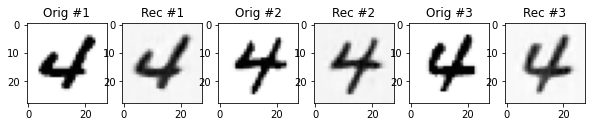

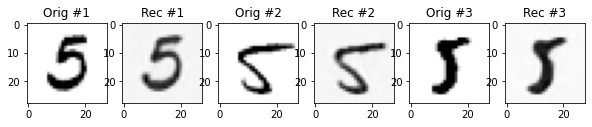

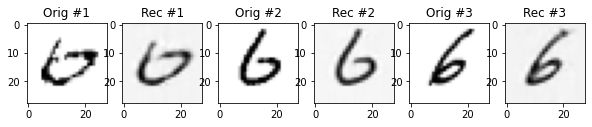

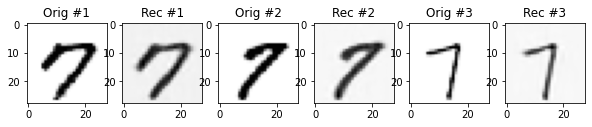

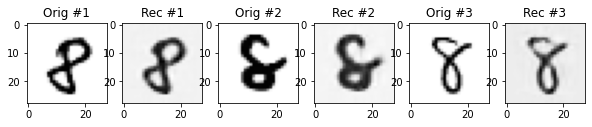

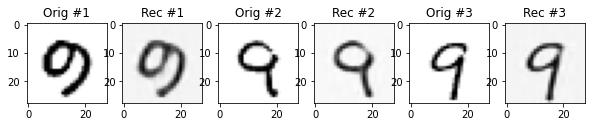

In [ ]:
def printDigitPrediction(model,data_c,data_x):
  model=model.to(device)
  with torch.no_grad():
      rows=1
      cols=6
      examples={}
      for i in range(10):
          examples[i]=[]
      for digit in range(10):
          found=0
          for i,cat in enumerate(data_c):
            if cat == digit:
              found +=1
              ind1 = i
              ind2 =i+1
              data_x_=data_x[:,ind1:ind2,:].to(device)
              data_x_ = data_x_.to(device)
              pred = model(data_x_).to(cpu)
              data_x_=data_x_.to(cpu)
              examples[digit].append((data_x[:,ind1,:],pred[:,0,:]))
            if found == 3:
              break
      for digit in range(10):
          fig = plt.figure(figsize=(10, 10))
          index=1
          d_ex = examples[digit]
          for i,(orig,pred) in enumerate(d_ex):
              fig.add_subplot(rows,cols,index)
              plt.title('Orig #'+str(i+1))
              plt.imshow(orig, cmap='Greys')
              index+=1
              fig.add_subplot(rows,cols,index)
              plt.title('Rec #'+str(i+1))
              plt.imshow(pred, cmap='Greys')
              index+=1
          plt.show()
printDigitPrediction(model_mnist, mnist_test_c,mnist_test_x)

### 3.2.2 Modify the network to additionally allow image classification
We added another Linear layer to learn a function from the last hidden state to the classification.</br>
We added the predict method for classification.</BR>
The forward will now additionally return a softmax for the probability of the classes.</br>
During training we will add the previous loss to the cross entropy of the classification.

In [ ]:
class LSTM_AEC(nn.Module):

    def __init__(self, input_size, hidden_size, num_of_class): 
        super(LSTM_AEC, self).__init__()
        self.softmax = torch.nn.Softmax(dim=2)
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.lstmEncoder = nn.LSTM(input_size = input_size, hidden_size = hidden_size)
        self.num_of_class=num_of_class
        self.lstmDecoder = nn.LSTM(input_size = hidden_size, hidden_size = hidden_size)

        # The linear layer that maps from hidden state space to tag space
        self.hidden2output = nn.Linear(hidden_size, input_size)
        self.hidden2numOfClass = nn.Linear(hidden_size, num_of_class)
        

    def forward(self, x):
        lstm_out, (hidden,cell) = self.lstmEncoder(x.view(x.shape[0], x.shape[1], self.input_size))
        hidden = hidden.repeat(x.shape[0],1,1)
        lstm_out, (hidden,_) = self.lstmDecoder(hidden.view(x.shape[0], x.shape[1], -1))
        output = self.hidden2output(lstm_out)
        classification = self.hidden2numOfClass(hidden)
        classification = self.softmax(classification) 
        return output,classification

    def predict(self, x):
      output,classification = self.forward(x)
      return output,torch.argmax(classification, dim=2)

In [ ]:
model_mnist_c = LSTM_AEC(input_size=28, hidden_size=100,num_of_class=10)
mnist_c_hist=train_model(model_mnist_c, mnist_train_x, mnist_test_x, 10, batchSize=32,clip_max_grad=1, lr=1e-3,train_c=mnist_train_c, val_c=mnist_test_c)

#### We will compare the two architectures (only reconstring and with classification).</br>
In the first graph, "MNIST classification accuracy," we can see that after the first epoch, we are close to 95%, and in the epoch, the accuracy crosses 98%.
We think it is because the problem is simple, and we have significant data to learn with relation to the problem difficulty. We cannot compare traditional accuracy with the first architecture since it does not classify.

Because we do want to compare the accuracy of the two architectures, we tested the MSE of the model reconstructed sequences vs. the real sequence after each epoch (we of-coarse used the test data) during the architectures training (we saw that it could be used as an accuracy replacement in regression problems).
We can see in "Test MSE_loss" graph that the model which also classifies the image does not reconstruct at the same level, which makes sense because it updates the parameters with consideration of the prediction.

In the last graph, we can see the "Train loss vs. epochs". The "with classification" model computes the loss of the reconstruction and adds the classification loss (MSE + Cross entropy). We saw in the previous graph that the classification stays similar starting from the first epoch (95%-98%), so we can look at the classification loos as almost a constant, and we can see that the shape of the graphs is similar.

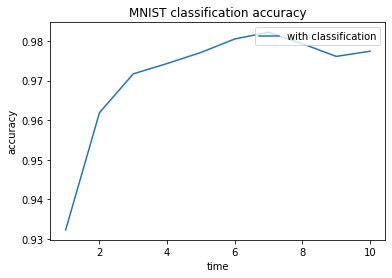

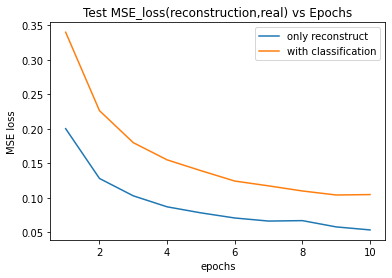

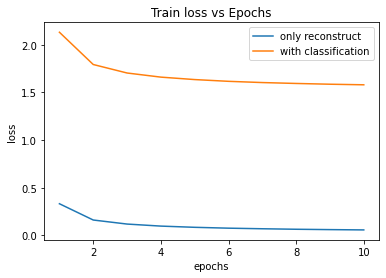

In [ ]:
plotLossAndAccuracyVsTime(mnist_hist,mnist_c_hist, 'only reconstruct','with classification')

### 3.2.3 Repeat 3.2.2 with pixel-by-pixel



_We will first change our data_

In [ ]:
def changeDataToPixelByPixel(data):
  batchSize=data.shape[1]
  ap = data.permute(1, 0, 2)
  b=torch.flatten(ap, start_dim=1, end_dim=2)
  c=b.permute(1,0)
  return c.view(-1,batchSize,1)

def returnToImageData(data):
  bSize = data.shape[1]
  rowSize = int(np.sqrt(data.shape[0]))
  c=data.permute(1,2,0).view(bSize,-1)
  func = nn.Unflatten(1, torch.Size([rowSize, rowSize]))
  d=func(c)
  return d.permute(1,0,2)

print('original train data size',mnist_train_x.size())
mnist_train_p_x = changeDataToPixelByPixel(mnist_train_x)
mnist_test_p_x = changeDataToPixelByPixel(mnist_test_x)
print('pixel by pixel train data size',mnist_train_p_x.size()) 

original train data size torch.Size([28, 60000, 28])
pixel by pixel train data size torch.Size([784, 60000, 1])


_Create and train the new model_

In [ ]:
device = cpu
mnist_pix = LSTM_AE(input_size=1, hidden_size=70)
mnist_pix_c = LSTM_AEC(input_size=1, hidden_size=70,num_of_class=10)

In [ ]:
mnist_pix_hist=train_model(mnist_pix, mnist_train_p_x, mnist_test_p_x, 5, batchSize=4096,clip_max_grad=1, lr=0.01)

In [ ]:
mnist_pix_c_hist=train_model(mnist_pix_c, mnist_train_p_x, mnist_test_p_x, 5, batchSize=2048,clip_max_grad=1, lr=0.01,train_c=mnist_train_c, val_c=mnist_test_c)

_The graphs for loss vs. epochs and accuracy vs. epochs for the two architectures_

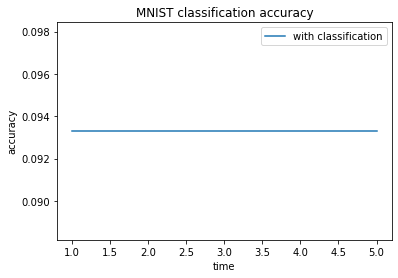

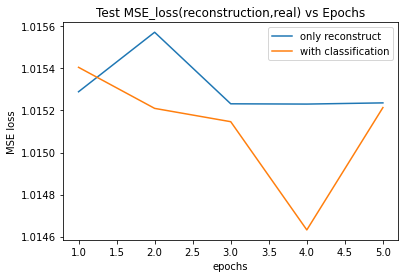

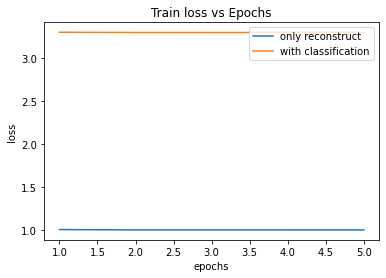

In [ ]:
plotLossAndAccuracyVsTime(mnist_pix_hist,mnist_pix_c_hist, 'only reconstruct','with classification')

You can see that our accuracy from the beginning is 9% ~ (like a guess) to the end. which means the model not learnt anything,
This makes sense to us because the sequence is very long and the number of epochs we made is very small.
We could not run it again because it ran all night.
And the architecture is good because we used the same thing for row by row.

## 3.3 Reconstructing and predicting S&P500
### The graphs of the daily max value for the stocks AMZN and GOOGL.
_Loading the S&P500 data and spliting it to train,validation and test sets, and taking only sequences with the same size(1007 days data)._

In [ ]:
import pandas as pd
from matplotlib import pyplot as plt
stocks = pd.read_csv('SP 500 Stock Prices 2014-2017.csv')
stocks = stocks.sort_values(['symbol','date'])

named_prices=stocks.sort_values(['symbol','date']).drop(['open','high','low','volume'], axis=1)
symbols = set(stocks['symbol'])
def getStockPrices(symbol):
  stock = named_prices[named_prices['symbol'] == symbol]
  a=torch.tensor(stock['close'].to_list())
  return (a,len(a))

sequencesData = []
for stock in symbols:
  data,s_len = getStockPrices(stock)
  if s_len == 1007:
    sequencesData.append(data)

In [ ]:
random.shuffle(sequencesData)
train_size = int(len(sequencesData)*0.6)
val_size = int(len(sequencesData)*0.2)
train_stock = sequencesData[:train_size]
val_stock = sequencesData[train_size:train_size+val_size]
test_stock = sequencesData[train_size+val_size:]

### 3.3.1 The graphs of the daily max value for the stocks AMZN and GOOGL.

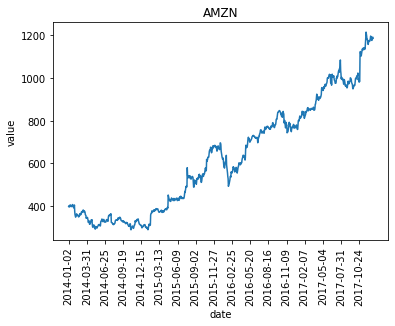

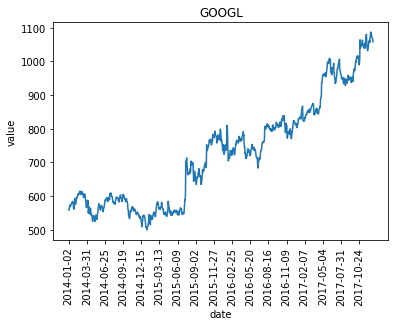

In [ ]:
def plot_max_day(stock_sym):
  stock = stocks[stocks["symbol"] == stock_sym]
  date = stock["date"]
  high = stock["high"]

  plt.plot(date, high)#, label=label_seq1)
  plt.xticks(date[::60],  rotation='vertical')
  plt.xlabel('date')
  plt.ylabel('value') 
  plt.title(stock_sym)
  plt.show()

plot_max_day('AMZN')
plot_max_day('GOOGL')

_We will split the sequences to ease learning since LSTM tend to forget in long series_</br>
Sequnces are split to 19 sub-sequnces of 53 elements.

In [ ]:
splitSeqSize = 53
def splitData(data):
    splitedSequenceData = []
    def spliteSequence(seq):
        res=[]
        for s in sequence.split(splitSeqSize):
            res.append(s/s.max())
        return res

    for sequence in data:
      splitedSequenceData.extend(spliteSequence(sequence))

    t_splitData = torch.stack(splitedSequenceData,dim=0)
    t_splitData = t_splitData.permute(1,0)
    t_splitData = t_splitData.view(splitSeqSize,-1,1)
    return t_splitData

train_stock_spl=splitData(train_stock)
val_stock_spl=splitData(val_stock)
test_stock_spl=splitData(test_stock)

### 3.3.2 Train the LSTM AE such that it reconstructs the stocks’ prices

In [ ]:
train_stock_spl=splitData(train_stock)
val_stock_spl=splitData(val_stock)
test_stock_spl=splitData(test_stock)

model_stock_rec = LSTM_AE(1, splitSeqSize-1)

hist_model_stock_rec = train_model(model_stock_rec, train_stock_spl, val_stock_spl, 100, batchSize=32,clip_max_grad=1, lr=1e-3)

_We will show how we reconstruct a stock price_</br>

we take 3 example stock from the test set and show them and their model reconstruct</br>
Each sequence is splitted to sub-sequences, each of them is normalized to be in the [0,1] range.</br>
We reconstruct the subsequences using our model, multiply back by the normalization factor and concatenate the subsequences. we then plot the original and reconstructed sequences.

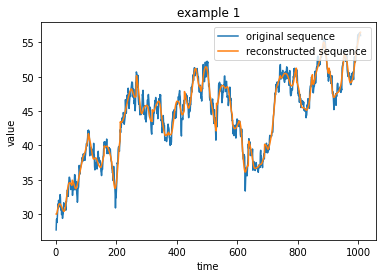

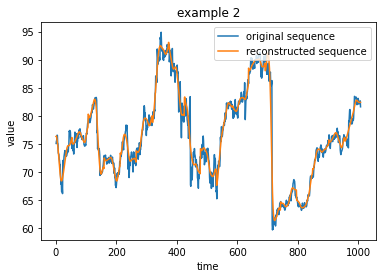

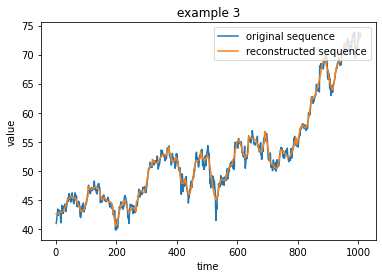

In [ ]:
def spliteSequence(seq):
    res=[]
    norm=[]
    orig=[]
    for s in seq.split(splitSeqSize):
        orig.append(s)
        norm.append(s.max())
        res.append(s/s.max())
    return res,norm,orig

def plot_orginal_stock_vs_reconstruct(originalSeq, stock_symbol="example stock"):
    splitSeq,norm,orig=spliteSequence(originalSeq)
    splitPredict = []
    predicted=None
    for i,subSeq in enumerate(splitSeq):
      pred_s = model_stock_rec(subSeq.view(len(subSeq),1,1))
      splitPredict.append(pred_s.view(-1)*norm[i])

    predicted = splitPredict[0]

    for i in range(1,len(splitPredict)):
        predicted=torch.cat((predicted, splitPredict[i]), 0)

    originalSeq = originalSeq.detach().numpy()
    predicted = predicted.detach().numpy()
    plot2seq(originalSeq, predicted, stock_symbol, label_seq1='original sequence', label_seq2='reconstructed sequence')

p = np.random.permutation(len(test_stock))
plot_orginal_stock_vs_reconstruct(test_stock[p[0]], stock_symbol="example 1")
plot_orginal_stock_vs_reconstruct(test_stock[p[1]], stock_symbol="example 2")
plot_orginal_stock_vs_reconstruct(test_stock[p[2]], stock_symbol="example 3")

We can see in the graphs above that the model learned to reconstruct the stock price sequence very well (it is not the identity function since we reduced the hidden state size to be less than the sequence size).

### 3.3.3 Reconstruction and Prediction of stock values
_Changing the network to predict next stock value_

In [ ]:
class LSTM_AEP(nn.Module):

    def __init__(self, input_size, hidden_size):
        super(LSTM_AEP, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.lstmEncoder = nn.LSTM(input_size = input_size, hidden_size = hidden_size)
        self.lstmDecoder = nn.LSTM(input_size = hidden_size, hidden_size = hidden_size)

        # The linear layers that maps from hidden state space to tag space
        self.hidden2output = nn.Linear(hidden_size, input_size)#reconstruct
        self.hidden2prediction = nn.Linear(hidden_size, input_size)#predict


    def forward(self, x):
        lstm_out, (hidden,cell) = self.lstmEncoder(x.view(x.shape[0], x.shape[1], self.input_size))
        hidden = hidden.repeat(x.shape[0],1,1)
        lstm_out, (hidden,_) = self.lstmDecoder(hidden.view(x.shape[0], x.shape[1], -1))
        output = self.hidden2output(lstm_out)
        prediction = self.hidden2prediction(lstm_out)
        return output,prediction


    def predict(self, x):
      return self.forward(x)

_creating the data_</br>
In the following way: (xt, yt) = (xt, xt+1) for every t ∈ [1, T − 1].
We actually store all the xt in one sequence and the corresponsding xt+1 on a second sequence with a corralation in the sequnces indexes, e.g. (xt, yt) = (predictionData_x[t],predictionData_y[t])

In [ ]:
splitSeqSize = 53
def preprocessDataForStockPrediction(seq):
    x=seq[:-1]
    y=seq[1:]
    return x,y
def splitDataPredict(data):
    splitedSequenceData_x = []
    splitedSequenceData_y = []
    def spliteSequencePredict(seq):
        res_x=[]
        res_y=[]
        for s in sequence.split(splitSeqSize):
            x,y=preprocessDataForStockPrediction(s/s.max())
            res_x.append(x)
            res_y.append(y)
        return res_x,res_y#sequence.split(splitSeqSize)#)[:int((len(sequence)/3)*3)-2].split(splitSeqSize)
    for sequence in data:
      x,y=spliteSequencePredict(sequence)
      splitedSequenceData_x.extend(x)
      splitedSequenceData_y.extend(y)

    t_splitData = torch.stack(splitedSequenceData_x,dim=0)
    t_splitData = t_splitData.permute(1,0)
    t_splitData_x = t_splitData.view(splitSeqSize-1,-1,1)

    t_splitData = torch.stack(splitedSequenceData_y,dim=0)
    t_splitData = t_splitData.permute(1,0)
    t_splitData_y = t_splitData.view(splitSeqSize-1,-1,1)
    return t_splitData_x,t_splitData_y

train_stock_x,train_stock_y=splitDataPredict(train_stock)
val_stock_x,val_stock_y=splitDataPredict(val_stock)
test_stock_x,test_stock_y=splitDataPredict(test_stock)

In [ ]:
print('Data example:')
print('x sequence section',np.array(val_stock_x[:3,0,:]))
print('y sequence section',np.array(val_stock_y[:3,0,:]))

Data example:
x sequence section [[0.99359334]
 [0.9945355 ]
 [0.9898248 ]]
y sequence section [[0.9945355]
 [0.9898248]
 [0.994724 ]]


_Training the model_

In [ ]:
model_aep = LSTM_AEP(1, splitSeqSize-3)
model_aep_hist=train_model(model_aep, train_stock_x, val_stock_x, 100, batchSize=32,clip_max_grad=1, lr=1e-3,train_c=train_stock_y, val_c=val_stock_y, predictionMSE=True)

#### The training loss vs. time and prediction loss vs. time.

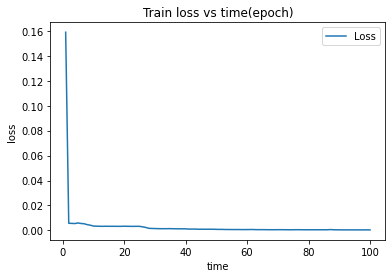

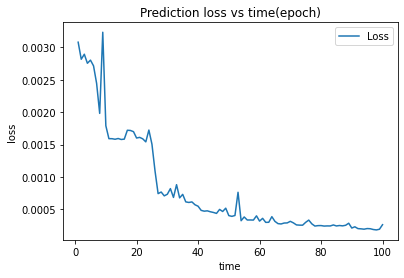

In [ ]:
plotLossVsTime(model_aep_hist)

### 3.3.4 Evaluate the model in the context of multi-step prediction.

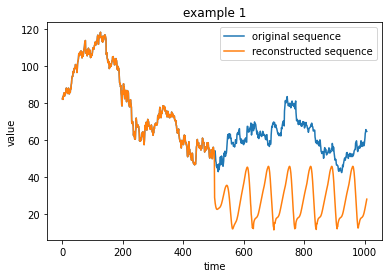

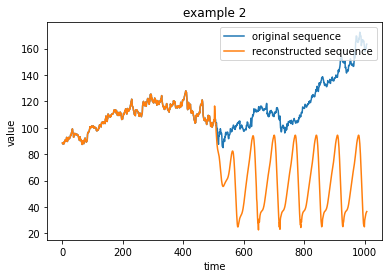

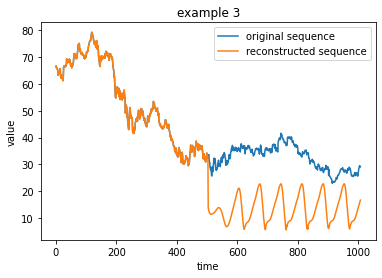

In [ ]:
def spliteSequence(seq):
    res=[]
    norm=[]
    orig=[]
    for s in seq.split(int(len(seq)/2)):
        orig.append(s)
        norm.append(s.max())
        res.append(s/s.max())
    return res,norm,orig

def plot_orginal_stock_vs_prediction(originalSeq, stock_symbol="example stock"):
    with torch.no_grad():
        splitSeq,norm,orig=spliteSequence(originalSeq)
        prediction=splitSeq[0]
        while prediction.shape[0] < originalSeq.shape[0]:
            rec,pred = model_aep(prediction.view(len(prediction),1,1))
            prediction = torch.cat((prediction.view(-1), pred.view(-1)[-1].view(-1)),0)

        prediction[:len(splitSeq[0])] *= norm[0]
        prediction[len(splitSeq[0]):] *= norm[1]
        originalSeq = originalSeq.detach().numpy()
        predicted = prediction.detach().numpy()
        plot2seq(originalSeq, predicted, stock_symbol, label_seq1='original sequence', label_seq2='reconstructed sequence')

p = np.random.permutation(len(test_stock))
plot_orginal_stock_vs_prediction(test_stock[p[0]], stock_symbol="example 1")
plot_orginal_stock_vs_prediction(test_stock[p[1]], stock_symbol="example 2")
plot_orginal_stock_vs_prediction(test_stock[p[2]], stock_symbol="example 3")

You can see that when we do multi-step
in the first half the reconstruction is very good,
in the second half we get a situation that the stock could have been,
(although it is smooth and without sharp changes) but see that the change from day to day makes sense
Apparently the more we rely on the predictions we got from the model the more we make mistakes and therefore we get something possible but not what really happened